# Portfolio Optimization Project 

Given a data set of monthly closing prices for 25 assets from Jan 1st, 2018 to Dec 1st 2020 (in-sample) and closing prices for the same assets in 2021 (out-of-sample), this project applies the optimization techniques to explore and optimize the financial portfolio performance. 

Among this project, besides the mathematics-oriented optimization techniques applied, I draw the Markowitz classifical efficient frontier and the resampled efficient frontier, and do the comparison between these frontiers to derive more insights about the portfolio investment.

In [ ]:
# Install package cvxpy 
! pip install cvxpy
! pip install cvxopt


In [ ]:
# import libraries 
import pandas as pd 
import numpy as np
import scipy 
import matplotlib.pyplot as plt 
import seaborn as sns 
import cvxpy as cp 
from sklearn.utils import resample


In [ ]:
from google.colab import files 
uploaded = files.upload()

#Read insample data into python 
df1 = insample = pd.read_csv ('monthly_closings_2018_to_2020.csv')


Saving monthly_closings_2018_to_2020.csv to monthly_closings_2018_to_2020 (5).csv


In [ ]:
#remove the date 
price = insample.iloc[:, 1:]


In [ ]:
from google.colab import files 
uploaded = files.upload()

#Read out of sample data into python 
df2 = outofsample = pd.read_csv ('monthly_closings_2021.csv')


Saving monthly_closings_2021.csv to monthly_closings_2021 (5).csv


## Section 1: From the in-sample data, compute the classical Markowitz and resampled Markowitz frontiers.

### 1.a Compute the matrix of monthly returns 

In [ ]:
# Compute the matrix of monthly returns as percent change of monthly closing values, reset indices 
monthly_return = price.pct_change().iloc[1:, :]
monthly_return.reset_index(inplace = True, drop = True)

# Display the matrix of monthly returns 
monthly_return.head()


,AMD,OXY,XLF,BABA,F,BAC,CCL,AMC,DAL,FB,...,UNH,MMM,AAL,MULN,QQQ,AAPL,XLE,FXI,JPM,V
0,-0.118632,-0.124983,-0.029253,-0.088844,-0.021902,0.003125,-0.065633,0.171875,-0.050555,-0.045856,...,-0.044852,-0.059840,-0.001289,-0.203552,-0.012928,0.063848,-0.108350,-0.103474,0.003732,-0.010384
1,-0.170107,-0.009756,-0.045030,-0.013968,0.044298,-0.065732,-0.013497,-0.063333,0.022751,-0.103914,...,-0.053767,-0.062399,-0.040370,0.193825,-0.042342,-0.054210,0.010039,0.000424,-0.047879,-0.025311
2,0.082587,0.203563,-0.000728,-0.027242,0.014440,0.001409,-0.038426,0.258175,-0.047254,0.076413,...,0.108330,-0.114477,-0.173788,0.139368,0.006689,-0.015020,0.102737,-0.006562,-0.010821,0.060692
3,0.261949,0.089827,-0.009836,0.109051,0.041367,-0.029412,-0.012369,-0.151862,0.035044,0.115000,...,0.021616,0.014610,0.014209,-0.153846,0.056729,0.130763,0.029942,-0.004901,-0.011283,0.030265
4,0.091770,-0.006176,-0.021707,-0.063027,-0.041558,-0.025304,-0.072632,0.074324,-0.077993,0.013244,...,0.015858,0.004236,-0.126119,0.095380,0.009290,-0.005599,-0.001052,-0.079871,-0.026259,0.014863


### 1.b Compute the covariance matrix and means of percent change matrix 

In [ ]:
#Compute and display the covariance matrix 
covariance_matrix = monthly_return.cov()
covariance_matrix.head()


,AMD,OXY,XLF,BABA,F,BAC,CCL,AMC,DAL,FB,...,UNH,MMM,AAL,MULN,QQQ,AAPL,XLE,FXI,JPM,V
AMD,0.028843,0.010047,0.005629,0.008224,0.003936,0.007298,0.009855,0.012855,0.005633,0.008891,...,0.006390,0.005025,0.007885,0.004682,0.006715,0.008149,0.007937,0.004949,0.005288,0.005519
OXY,0.010047,0.051093,0.010783,0.000525,0.011660,0.013617,0.028853,0.033722,0.015708,0.008105,...,0.006344,0.006841,0.019838,0.067743,0.007919,0.007815,0.022681,0.005063,0.010833,0.008036
XLF,0.005629,0.010783,0.004977,0.002570,0.005571,0.006360,0.009939,0.009833,0.006288,0.004390,...,0.002530,0.002981,0.007499,0.007233,0.003443,0.003999,0.007075,0.002379,0.005371,0.003235
BABA,0.008224,0.000525,0.002570,0.009454,0.003980,0.003723,0.002772,-0.000378,0.002931,0.005342,...,0.001693,0.003450,0.004603,0.006234,0.003009,0.003150,0.002754,0.003615,0.002055,0.001442
F,0.003936,0.011660,0.005571,0.003980,0.010637,0.006556,0.011245,0.008501,0.007986,0.006139,...,0.001890,0.002360,0.008268,0.014932,0.003579,0.004042,0.008031,0.002958,0.005860,0.003011


In [ ]:
# Convert the covariance matrix into the array form to facilitate latter analysis 
covariance = np.array(monthly_return.cov())

In [ ]:
# Compute the means of the percentage change matrix 
mean_list = np.mean(monthly_return, axis = 0)
mean_list



AMD     0.069673
OXY    -0.010903
XLF     0.003947
BABA    0.008313
F       0.003104
BAC     0.004515
CCL    -0.015180
AMC    -0.008164
DAL    -0.000681
FB      0.015239
AMZN    0.027025
GLD     0.010307
TSLA    0.090886
GOOG    0.013860
USO    -0.015670
UNH     0.014838
MMM    -0.005279
AAL    -0.023484
MULN    0.102116
QQQ     0.020076
AAPL    0.039391
XLE    -0.008184
FXI    -0.000428
JPM     0.008346
V       0.018778
dtype: float64

In [ ]:
# Cover the mean list into the array form to facilitate latter analysis 
mean = np.array(mean_list)

### 1.c Solve for the minimum variance portfolio 

In [ ]:
# Solve for the minimum variance portfolio 
w1 = cp.Variable(25)

# solve the minimizing variance optimization problem 
constraint1 = [sum(w1) == 1, w1 >= 0]

prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1,covariance)), [sum(w1) == 1, w1 >= 0])

prob1.solve(verbose = True)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 25, constraints m = 26
          nnz(P) + nnz(A) = 375
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   1.00e+02   1.00e-01   9.09e-04s
 150   9.2789e-04   6.49e-07   1.69e-07   4.23e-02   1.34e-02s
plsh   9.2789e-04   4.54e-19   1.07e-16   -----

0.0009278939303461065

In [ ]:
#Check constraint  
np.allclose(np.sum(w1.value),1)

True

In [ ]:
# Display the minimum variance portfolio (expected return, minimum variance, etc.)
w_minvar = w1.value
var_minvar = np.dot(w_minvar, np.dot(covariance, w_minvar)) 
ret_minvar = np.dot(mean, w_minvar)
print("Minimum variance portfolio:\n")
print("   Solution status =", prob1.status)
print("    Solution value =", prob1.value)
print("          Variance =", var_minvar)
print("   Expected return =", ret_minvar)
print("Standard deviation =", np.sqrt(var_minvar))

Minimum variance portfolio:

   Solution status = optimal
    Solution value = 0.0009278939303461065
          Variance = 0.0009278939303461066
   Expected return = 0.008653285914910979
Standard deviation = 0.030461351420219468


In [ ]:
# Display the minimum variance portfolio weight 
w1.value

array([ 2.34711076e-19,  5.74341943e-20,  8.04974643e-21,  8.47497298e-20,
        1.98801020e-20,  1.09424374e-20,  2.73065413e-20,  2.72299411e-19,
        5.54485957e-02,  1.08374508e-19,  8.96592846e-20,  6.59194971e-01,
       -6.72526425e-20,  2.57096580e-20,  1.76013193e-03,  8.87191244e-02,
        5.48842212e-02, -5.82451239e-20, -4.53773627e-19,  3.42087380e-20,
       -3.00374544e-20,  8.76648789e-20,  9.01180838e-02, -1.21197912e-21,
        4.98748717e-02])

In [ ]:
print("As we can see in the above, the minimum variance portfolio has the the minimum variance 0.0009278939303461067 and the expected return is 0.008653285914910979.")


As we can see in the above, the minimum variance portfolio has the the minimum variance 0.0009278939303461067 and the expected return is 0.008653285914910979.


### 1.d Solve for the maximum return portfolio 

In [ ]:
#Solve for the maximum return portfolio 
w2 = cp.Variable(25)

# solve the maximing return optimization problem 
prob2 = cp.Problem(cp.Maximize(mean.T@w2),[sum(w2) == 1, w2>= 0])
prob2.solve(verbose = True)



0.1021163469313111

In [ ]:
# Display the maximum return portfolio (expected return, variance, etc.)
w_maxRet = w2.value
var_maxRet = np.dot(w_maxRet, np.dot(covariance, w_maxRet))
ret_maxRet = np.dot(mean, w_maxRet)
print("Maximum return portfolio:\n")
print("   Solution status =", prob2.status)
print("    Solution value =", prob2.value)
print("   Expected return =", ret_maxRet)
print("          Variance =", var_maxRet)
print("Standard deviation =", np.sqrt(var_maxRet))

Maximum return portfolio:

   Solution status = optimal
    Solution value = 0.1021163469313111
   Expected return = 0.10211634693131112
          Variance = 0.3397485196506799
Standard deviation = 0.582879506974366


In [ ]:
# display the maximum return portfolio weight
w2.value

array([4.00446549e-11, 2.33109317e-11, 2.11897368e-11, 2.02514107e-11,
       2.13526338e-11, 2.10766681e-11, 2.36702200e-11, 2.30281295e-11,
       2.20156300e-11, 1.84127151e-11, 1.42266925e-11, 1.97676588e-11,
       1.08469522e-09, 1.88147929e-11, 2.37055006e-11, 1.85314364e-11,
       2.26815434e-11, 2.41212013e-11, 9.99999998e-01, 1.68558540e-11,
       8.78989931e-12, 2.30303345e-11, 2.19747289e-11, 2.02437383e-11,
       1.72961027e-11])

In [ ]:
print("As seen in the above, the maximum return portfolio has the variance 0.33974851965068 and the expected return 0.10211634693131112. ")

As seen in the above, the maximum return portfolio has the variance 0.33974851965068 and the expected return 0.10211634693131112. 


### 1.e Compute the classical Markowitz efficient frontier 

In [ ]:
# Take the target returns between the ret_minvar and ret_maxret 
targetLen = 50
targetRet = np.linspace(ret_minvar,ret_maxRet,targetLen)
targetRet

array([0.00865329, 0.0105607 , 0.0124681 , 0.01437551, 0.01628292,
       0.01819033, 0.02009774, 0.02200515, 0.02391256, 0.02581997,
       0.02772738, 0.02963479, 0.0315422 , 0.03344961, 0.03535702,
       0.03726443, 0.03917184, 0.04107925, 0.04298666, 0.04489406,
       0.04680147, 0.04870888, 0.05061629, 0.0525237 , 0.05443111,
       0.05633852, 0.05824593, 0.06015334, 0.06206075, 0.06396816,
       0.06587557, 0.06778298, 0.06969039, 0.0715978 , 0.07350521,
       0.07541262, 0.07732002, 0.07922743, 0.08113484, 0.08304225,
       0.08494966, 0.08685707, 0.08876448, 0.09067189, 0.0925793 ,
       0.09448671, 0.09639412, 0.09830153, 0.10020894, 0.10211635])

In [ ]:
# Define optimization problem 
w = cp.Variable(25)
eps = cp.Parameter()

# write the efficient frontier optimization problem 

prob3 = cp.Problem(cp.Minimize(cp.quad_form(w, covariance)),
          [mean.T@w >= eps,
                  sum(w) == 1,
                  w >= 0])

# compute the efficient frontier 
w_front = []
var_front = []
ret_front = []
for epsilon in targetRet:
    eps.value = epsilon
    prob3.solve()
    w_front.append(w.value)
    var_front.append(np.dot(w.value, np.dot(covariance, w.value)))
    ret_front.append(np.dot(mean,w.value))

# Print efficient frontier optimization problem results
print("\nSolution status: ", prob3.status)
print("Solution optimal value: ", prob3.value)
print("Solution w: ")
print(w.value)


Solution status:  optimal
Solution optimal value:  0.33808184042479533
Solution w: 
[-3.69310785e-06 -1.73732232e-05 -1.46513622e-05 -1.39387928e-05
 -1.48461009e-05 -1.45522788e-05 -1.78618558e-05 -1.64950255e-05
 -1.54703989e-05 -1.27246575e-05 -1.08433441e-05 -1.35992466e-05
  3.02308681e-03 -1.29547906e-05 -1.79986306e-05 -1.28098616e-05
 -1.61873492e-05 -1.93337499e-05  9.97301088e-01 -1.19644126e-05
 -8.72463646e-06 -1.66768143e-05 -1.53960167e-05 -1.39080658e-05
 -1.21554690e-05]


### 1.f Compute the resampled efficient frontier 

In [ ]:
# get the sample size of insample 
sample_size = monthly_return.shape[0]
sample_size

35

In [ ]:
# Resample the dataset for 100 times and find the classical efficient frontier for each resampled dataset 

# Create the belowing list to store the relevant resampling results 
covariance_resample_list = []  
mean_resample_list = []
var_minvar_list = []
ret_minvar_list = []
var_maxret_list = []
ret_maxret_list = []
var_frontier_list = []
ret_frontier_list = []
w_frontier_list = []


np.random.seed(10)

# Resample 100 times 
for i in range(100):
    # get the resample data by drawing from the multilvariate normal distribution with mean and covariance
    X_resample = np.random.multivariate_normal(mean, covariance, sample_size)
    
    # Calculate covariance matrix for resampled data and convert it to array 
    covariance_res = np.cov(X_resample.T)
    
    #calculate the mean for resampled data and convert it to array
    mean_res = np.mean(X_resample, axis = 0)

    
    #compute the minimum variance portfolio
    w1_res = cp.Variable(25)
    constraint1_res = [sum(w1_res) == 1, w1_res >= 0]
    prob1_res = cp.Problem(cp.Minimize(cp.quad_form(w1_res,covariance_res)), [sum(w1_res) == 1, w1_res >= 0])
    prob1_res.solve(verbose = False)
    
    w_minvar_res = w1_res.value #compute the minimum variance portfolio weights
    ret_minvar_res = np.dot(mean_res, w_minvar_res) #compute the minimum variance portfolio return 
    var_minvar_res = np.dot(w_minvar_res, np.dot(covariance_res,w_minvar_res)) #compute the minimum variance portfolio variance 

    
    #compute the maximum return portfolio 
    w2_res = cp.Variable(25)
    prob2_res = cp.Problem(cp.Maximize(mean_res.T@w2_res),[sum(w2_res) == 1, w2_res>= 0])
    prob2_res.solve(verbose = False)

    
    w_maxret_res = w2_res.value #compute the maximum return portfolio weights 
    ret_maxret_res = np.dot(mean_res, w_maxret_res) #compute the maximum return portfolio return 
    var_maxret_res = np.dot(w_maxret_res, np.dot(covariance_res, w_maxret_res)) #compute the maximum return portfolio variance 
    
    # calculate the target return for resampeld data 
    target_ret_res = np.linspace(ret_minvar_res, ret_maxret_res, 50)
    
    # Define optimization problem and compute one portfolio on efficient frontier 
    w_res = cp.Variable(25)
    eps_res = cp.Parameter()
    prob3_res = cp.Problem(cp.Minimize(cp.quad_form(w_res, covariance_res)),
                 [mean_res.T@w_res >= eps_res,
                  sum(w_res) == 1,
                  w_res >= 0])
    w_front_res = []
    var_front_res = []
    ret_front_res = []
    for epsilon in target_ret_res[:-1]:
        eps_res.value = epsilon
        prob3_res.solve(verbose = False)
        w_front_res.append(w_res.value) 
        var_front_res.append(np.dot(w_res.value, np.dot(covariance_res, w_res.value)))
        ret_front_res.append(np.dot(mean_res, w_res.value))
    
    w_front_res.append(w_maxret_res)
    var_front_res.append(var_maxret_res)
    ret_front_res.append(ret_maxret_res)
    
    
    # Store results for each resampling 
    covariance_resample_list.append(covariance_res)
    mean_resample_list.append(mean_res)
    var_minvar_list.append(var_minvar_res)
    ret_minvar_list.append(ret_minvar_res)
    var_maxret_list.append(var_maxret_res)
    ret_maxret_list.append(ret_maxret_res)
    var_frontier_list.append(var_front_res)
    ret_frontier_list.append(ret_front_res)
    w_frontier_list.append(w_front_res)
    




        

In [ ]:
#Compute the average weights at each return level 
avg_w_frontier = np.mean(np.array(w_frontier_list), axis = 0)


In [ ]:
#Compute the resampled efficient frontier based on the average weights and original mean & covariance 
var_frontier_resample = []
ret_frontier_resample = []
for avgfrontier in avg_w_frontier: 
    ret_frontier_resample.append(np.dot(mean,avgfrontier))
    var_frontier_resample.append(np.dot(avgfrontier, np.dot(covariance, avgfrontier)))

 ## Section2: Using the frontiers, compute three portfolios along classical and resampled frontiers. Compare the performance of each of portfolios on out-of-sample data. 

### 2.a  On the classical frontier, find the minimum variance, maximum return, and sharpe ratio portfolio weights.

In [ ]:
# On the classical frontier, find and display the minimum variance weight
min_var_weight = w_front[0]
min_var_weight

array([ 3.27231831e-19, -1.14158479e-20, -8.31044264e-22,  1.11997265e-19,
        1.90860299e-20,  1.70009911e-20, -2.67194251e-20,  8.07705709e-20,
        5.54485957e-02,  8.99771706e-20,  9.08772980e-20,  6.59194971e-01,
        9.71760135e-20,  3.48214411e-20,  1.76013193e-03,  8.87191244e-02,
        5.48842212e-02, -8.25234018e-20, -1.26897129e-20,  4.97872186e-20,
        4.42501729e-20,  2.33161871e-20,  9.01180838e-02,  8.74792459e-21,
        4.98748717e-02])

In [ ]:
# On the calssical frontier, find and display the maximum return weight
max_ret_weight = w_front[len(targetRet)-1]
max_ret_weight

array([-3.69310785e-06, -1.73732232e-05, -1.46513622e-05, -1.39387928e-05,
       -1.48461009e-05, -1.45522788e-05, -1.78618558e-05, -1.64950255e-05,
       -1.54703989e-05, -1.27246575e-05, -1.08433441e-05, -1.35992466e-05,
        3.02308681e-03, -1.29547906e-05, -1.79986306e-05, -1.28098616e-05,
       -1.61873492e-05, -1.93337499e-05,  9.97301088e-01, -1.19644126e-05,
       -8.72463646e-06, -1.66768143e-05, -1.53960167e-05, -1.39080658e-05,
       -1.21554690e-05])

In [ ]:
# On the classical frontier, find the sharpe ratio weight 
risk_free_rate = 0.002 

ret_front_array = np.array(ret_front)
var_front_array = np.array(var_front)

# Calculate the list of sharpe ratios of portfolios on the classical frontier 
sharpe_ratio_classical= (ret_front_array - risk_free_rate)/np.sqrt(var_front_array)
sharpe_ratio_classical 

array([0.21841729, 0.27797437, 0.32773841, 0.36826892, 0.40084006,
       0.42615505, 0.44633031, 0.4624906 , 0.47545637, 0.48589632,
       0.49435103, 0.50109046, 0.50645874, 0.51074942, 0.5141787 ,
       0.51666607, 0.51850325, 0.51976041, 0.52057517, 0.52104411,
       0.52124292, 0.52123104, 0.52105527, 0.52075255, 0.52035209,
       0.51987708, 0.51934591, 0.51877323, 0.51817071, 0.51754764,
       0.51691144, 0.51626799, 0.51562199, 0.51497714, 0.51433639,
       0.51370202, 0.51305877, 0.51222578, 0.50606699, 0.49190377,
       0.47256729, 0.4507326 , 0.42825704, 0.40634554, 0.38566497,
       0.34299185, 0.28488889, 0.23609746, 0.19944177, 0.17218151])

In [ ]:
# Find and display the optimal sharpe ratio weights on the classical frontier 
sharpe_ratio_classical_weight = w_front[sharpe_ratio_classical.argmax()]
print(sharpe_ratio_classical.argmax())
print(sharpe_ratio_classical_weight)

20
[ 3.03145246e-01 -5.30561024e-06 -1.62004752e-06 -6.56583631e-07
 -1.61935898e-06 -1.94628171e-06 -4.55772788e-06 -5.86979133e-06
 -2.61723444e-06 -1.03464147e-06 -4.15306274e-07  4.07769810e-01
  1.68198785e-01 -9.44505366e-07 -2.72697665e-06 -7.81266516e-07
 -1.57975037e-06 -3.63964216e-06  2.27431086e-02 -6.76639004e-07
  9.81855846e-02 -3.04851736e-06 -1.16261019e-06 -1.51716197e-06
 -8.15205306e-07]


### 2.b On the resampled frontier, find minimum variance, maximum return and sharpe ratio portfolio weights.

In [ ]:
# On the resampled efficient frontier, find and display the minimum variance weight 
min_var_res_weight = avg_w_frontier[0]
min_var_res_weight

array([-9.26579919e-08,  8.22351018e-05, -6.73352939e-09,  2.93301128e-03,
        4.00888414e-03, -3.92143792e-09,  8.35427238e-09,  7.38381773e-03,
        4.02572561e-02, -7.06651839e-09,  6.13803091e-03,  6.25981702e-01,
       -7.08559273e-08,  1.57941807e-02,  9.98081962e-03,  9.04684945e-02,
        6.84753672e-02,  2.80366523e-04,  6.06527682e-04, -2.23975844e-08,
        1.49819572e-03, -9.15901368e-09,  7.57890032e-02,  1.15640648e-02,
        3.87582471e-02])

In [ ]:
# On the resampled efficient frontier, find and display the maximum return weight 
max_ret_res_weight = avg_w_frontier[len(target_ret_res)-1]
max_ret_res_weight

array([1.79999996e-01, 1.40992257e-10, 1.26107286e-10, 1.83298674e-10,
       1.44730100e-10, 1.33588526e-10, 1.46508876e-10, 1.77068654e-10,
       1.50961493e-10, 1.63702156e-10, 1.85223977e-10, 1.97768870e-10,
       4.19999998e-01, 1.30851931e-10, 1.84656030e-10, 1.78185821e-10,
       1.49348588e-10, 1.59251214e-10, 3.90000002e-01, 1.57462250e-10,
       1.00000005e-02, 1.34682823e-10, 1.38452665e-10, 1.31260187e-10,
       1.92972636e-10])

In [ ]:
# On the resampled efficient frontier, find and display the sharpe ratio weight 

ret_front_res_array = np.array(ret_frontier_resample)
var_front_res_array = np.array(var_frontier_resample)

# Calculate the list of sharpe ratios of the portfolios on the resampled frontier 
sharpe_ratio_resample = (ret_front_res_array - risk_free_rate)/np.sqrt(var_front_res_array)
sharpe_ratio_resample

array([0.21013732, 0.25120872, 0.28754394, 0.31959847, 0.34763791,
       0.37224017, 0.39321518, 0.41095165, 0.42544749, 0.43719685,
       0.44659474, 0.45401615, 0.46008602, 0.46491363, 0.46868601,
       0.4719798 , 0.47496353, 0.47745874, 0.47968517, 0.48161524,
       0.48352252, 0.48522711, 0.48667143, 0.48777423, 0.48862189,
       0.48931757, 0.48897272, 0.48831035, 0.48731991, 0.48547618,
       0.48298052, 0.47962811, 0.4753892 , 0.47065263, 0.46557757,
       0.45958303, 0.45333381, 0.4467215 , 0.4396119 , 0.43223812,
       0.42433551, 0.41586711, 0.40620571, 0.39656626, 0.38559506,
       0.37356243, 0.36141396, 0.35007386, 0.33924712, 0.32734582])

In [ ]:
# Find and display the optimal sharpe ratio weights on the resampled frontier 
sharpe_ratio_resample_weight = avg_w_frontier[sharpe_ratio_resample.argmax()]
print(sharpe_ratio_resample.argmax()) 
print(sharpe_ratio_resample_weight) 

25
[ 2.92721720e-01  1.06517340e-04 -2.66156689e-06  1.70726492e-02
  6.07899160e-03 -2.88061432e-06 -5.06585330e-06  7.50977292e-04
 -3.50507448e-06  1.13393102e-02  1.46334040e-02  1.24190752e-01
  2.08047309e-01  2.00653112e-02  1.38851062e-03  6.65475679e-02
  1.78445619e-04 -5.19959717e-06  6.30565499e-02 -1.75296360e-06
  1.04631298e-01 -3.82101656e-06 -2.58270844e-06  1.88301399e-02
  5.03880168e-02]


### 2.c For each of the 6 portfolios, calculate the expected return on the 2021 (out-of-sample) data 

In [ ]:
# Drop date 
price_2021 = outofsample.iloc[:, 1:]

# Extract only the first month and the last month to calculate the yearly return 
price_2021_first_last = price_2021.drop(price_2021.index[1:11])
price_2021_first_last.reset_index(inplace = True, drop = True)

In [ ]:
# Compute percentage change of return for out-of-sample data 
return_2021 = price_2021_first_last.pct_change().iloc[1:,:]

return_2021

,AMD,OXY,XLF,BABA,F,BAC,CCL,AMC,DAL,FB,...,UNH,MMM,AAL,MULN,QQQ,AAPL,XLE,FXI,JPM,V
1,0.68029,0.446726,0.366112,-0.53201,0.982391,0.522067,0.077665,1.051282,0.029505,0.302017,...,0.521509,0.043312,0.04601,-0.584591,0.269255,0.353931,0.458557,-0.256478,0.261573,0.128286


In [ ]:
# From the classical efficient frontier to find the minimum variance porfolio return rate on outofsample data 
ret_minvar_2021 = np.dot(return_2021, min_var_weight)
ret_minvar_2021

array([0.02822425])

In [ ]:
# From the classical efficient frontier to find the maximum return portfolio return rate on outofsample data 
ret_maxret_2021 = np.dot(return_2021, max_ret_weight)
ret_maxret_2021

array([-0.58210478])

In [ ]:
# From the classical efficient frontier to find the sharpe ratio portfolio return rate on outofsample data 
ret_sharperatio_2021 = np.dot(return_2021,sharpe_ratio_classical_weight)
ret_sharperatio_2021

array([0.27956668])

In [ ]:
# Calculate the expected return on out-of-sample given $1000 initial investment for above three portfolios on the classical frontier 
print('Given the initial investment of $1000,\n')
print("On the classical efficient frontier, the minimum variance portfolio's return on out-of-sample data is $", ret_minvar_2021*1000)
print("On the classical efficient frontier, the maximum return portfolio's return on out-of-sample data is $", ret_maxret_2021*1000)
print("On the classical efficient frontier, the optimal sharpe ratio portfolio's return on Out-of-sample data is $", ret_sharperatio_2021*1000)


Given the initial investment of $1000,

On the classical efficient frontier, the minimum variance portfolio's return on out-of-sample data is $ [28.22424688]
On the classical efficient frontier, the maximum return portfolio's return on out-of-sample data is $ [-582.10477944]
On the classical efficient frontier, the optimal sharpe ratio portfolio's return on Out-of-sample data is $ [279.56668474]


In [ ]:
# From the resampled efficient frontier to find the minimum variance portfolio return rate on outofsample data 
ret_minvar_res_2021 =  np.dot(return_2021,min_var_res_weight)
ret_minvar_res_2021

array([0.05906256])

In [ ]:
# From the resampled efficient frontier to find the maximum return portfolio return rate on outofsample data 
ret_maxret_res_2021 = np.dot(return_2021, max_ret_res_weight)
ret_maxret_res_2021 

array([0.03733405])

In [ ]:
# From the resampled efficient frontier to find the optimal sharpe ratio portfolio return on outofsample data 
ret_sharperatio_res_2021 = np.dot(return_2021,sharpe_ratio_resample_weight)
ret_sharperatio_res_2021

array([0.32729008])

In [ ]:
# Calculate the expected return on out-of-sample data given $1000 initial investment for above three portfolios on the resampled efficient frontiet\
print('Given the initial investment of $1000,\n')
print("On the resampled efficient frontier, the minimum variance portfolio's return on out-of-sample data is $", ret_minvar_res_2021*1000)
print("On the resampled efficient frontier, the maximum return portfolio's return on out-of-sample data is $", ret_maxret_res_2021*1000)
print("On the resampled efficient frontier, the optimal sharpe ratio portfolio's return on Out-of-sample data is $", ret_sharperatio_res_2021*1000)


Given the initial investment of $1000,

On the resampled efficient frontier, the minimum variance portfolio's return on out-of-sample data is $ [59.06256394]
On the resampled efficient frontier, the maximum return portfolio's return on out-of-sample data is $ [37.33405228]
On the resampled efficient frontier, the optimal sharpe ratio portfolio's return on Out-of-sample data is $ [327.29007761]


## Section3: Plot the classifical and resampled efficient frontiers 

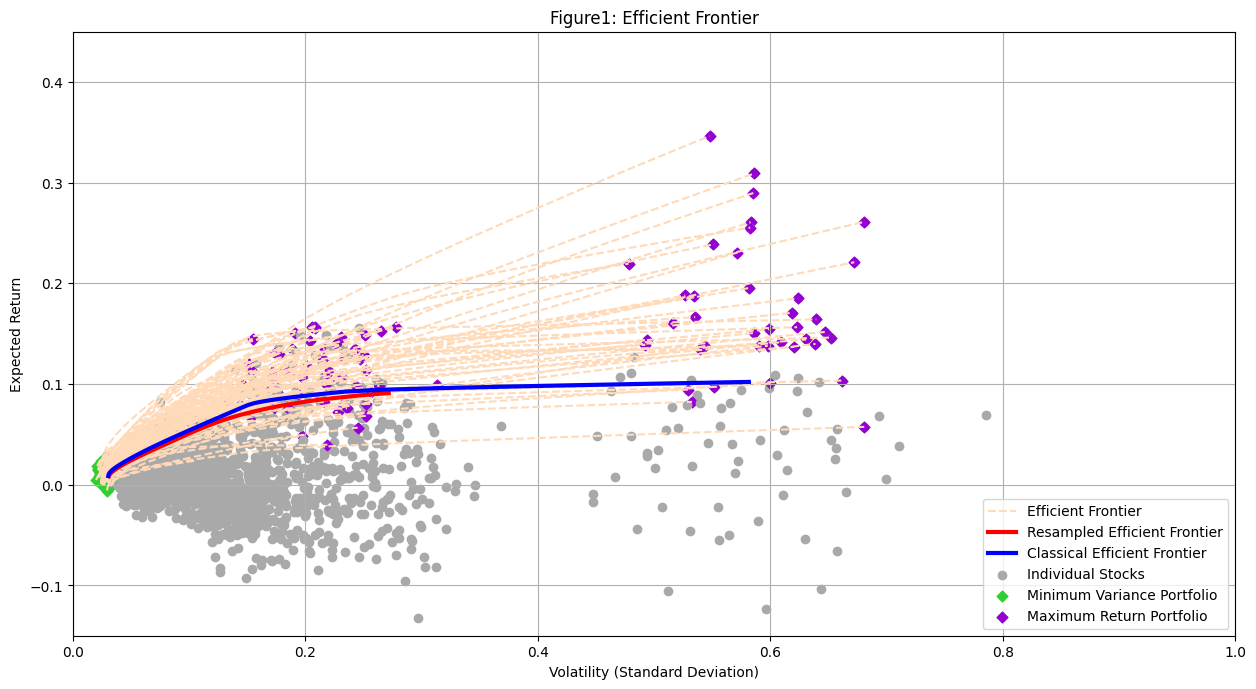

In [ ]:
#Draw the classical efficient frontier and resampled efficient frontier 
fig=plt.figure(figsize=(15,8), dpi= 100, facecolor='w', edgecolor='k')
ax2 = plt.gca()

for i in range(100):
     # Plot volatility versus expected return for individual stocks
    ax2.scatter(x=np.sqrt(np.diag(covariance_resample_list[i])), y=mean_resample_list[i], color='darkgray', label='Individual Stocks' if i == 0 else "")
    
    # Plot volatility versus expected return for mimimum variance portfolio
    ax2.scatter(x=np.sqrt(var_minvar_list[i]), y=ret_minvar_list[i], marker='D', s=30,  color='limegreen', label='Minimum Variance Portfolio' if i == 0 else "")

    # Plot volatility versus expected return for maximum return portfolio
    ax2.scatter(x=np.sqrt(var_maxret_list[i]), y=ret_maxret_list[i],  marker='D', s=30, color='darkviolet', label='Maximum Return Portfolio' if i == 0 else "")

    # Plot efficient frontier
    ax2.plot(np.sqrt(var_frontier_list[i]), ret_frontier_list[i], '--', color='peachpuff', label='Efficient Frontier' if i == 0 else "")

#Plot the resampled efficient frontier
ax2.plot(np.sqrt(var_frontier_resample), ret_frontier_resample, color='red', linewidth=3, label='Resampled Efficient Frontier')

#Plot the classical mean-variance efficient frontier
ax2.plot(np.sqrt(var_front), ret_front, color='blue', linewidth=3, label='Classical Efficient Frontier')

plt.xlim([0,1])
plt.ylim([-0.15,0.45])
ax2.set_xlabel('Volatility (Standard Deviation)')
ax2.set_ylabel('Expected Return')
plt.title('Figure1: Efficient Frontier')
ax2.legend(loc="lower right")
ax2.grid()
plt.show()




## Section4: Plot the portfolio compositions for classical frontiers and resampled frontiers

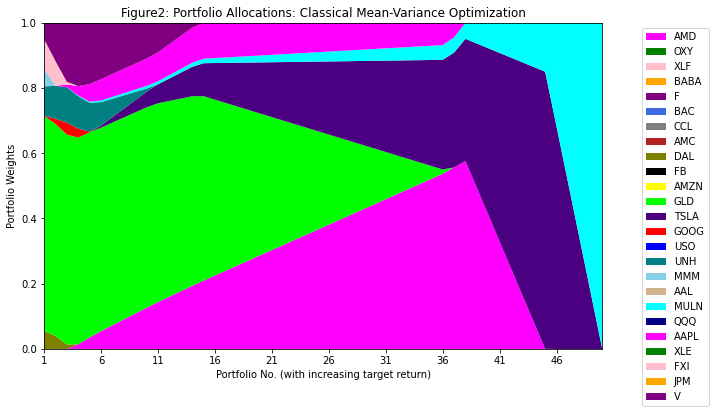

In [ ]:
# Plot portfolio compositions for classical frontiers 
x_tick = np.arange(len(targetRet))+1
color_list = ['fuchsia','green','pink','orange','purple','royalblue','grey','firebrick','olive','black','yellow','lime','indigo','red','blue','teal','skyblue','tan','cyan','navy']
plt.figure(figsize=(10, 6))
plt.stackplot(x_tick, np.array(w_front).T, colors=color_list)
plt.legend(df1.columns[1:], bbox_to_anchor=(1.2, 1))
plt.xlim((1,len(targetRet)))
plt.ylim((0,1))
plt.xticks(np.arange(1,len(targetRet)+1,5))
plt.xlabel("Portfolio No. (with increasing target return)")
plt.ylabel("Portfolio Weights")
plt.title("Figure2: Portfolio Allocations: Classical Mean-Variance Optimization")
plt.show()

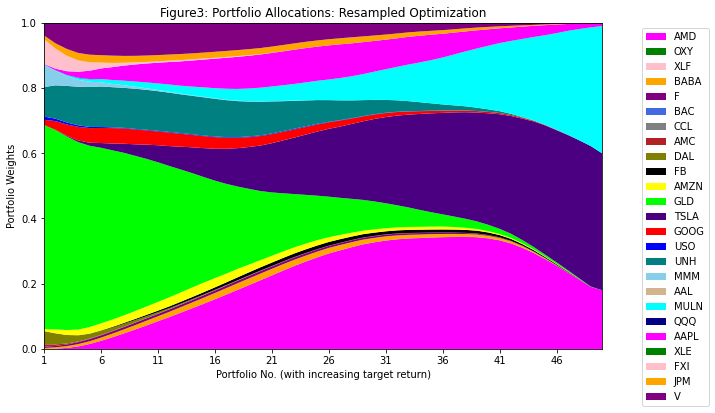

In [ ]:
# Plot the portfolio compositions for resampled frontiers
# Plot portfolio compositions for classical frontiers 
x_tick = np.arange(len(targetRet))+1
color_list = ['fuchsia','green','pink','orange','purple','royalblue','grey','firebrick','olive','black','yellow','lime','indigo','red','blue','teal','skyblue','tan','cyan','navy']
plt.figure(figsize=(10, 6))
plt.stackplot(x_tick,np.array(avg_w_frontier).T, colors=color_list)
plt.legend(df1.columns[1:], bbox_to_anchor=(1.2, 1))
plt.xlim((1,len(targetRet)))
plt.ylim((0,1))
plt.xticks(np.arange(1,len(targetRet)+1,5))
plt.xlabel("Portfolio No. (with increasing target return)")
plt.ylabel("Portfolio Weights")
plt.title("Figure3: Portfolio Allocations: Resampled Optimization")
plt.show()